In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [36]:
# imports
import random
import shutil
import math

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [7]:
data = '/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_1.parquet'
df = pd.read_parquet(data)
df.head(20)

,sensor_id,time,charge,auxiliary
event_id,,,,
24,3918,5928,1.325,True
24,4157,6115,1.175,True
24,3520,6492,0.925,True
24,5041,6665,0.225,True
24,2948,8054,1.575,True
24,860,8124,0.675,True
24,2440,8284,1.625,True
24,1743,8478,0.775,True
24,3609,8572,1.025,True


In [8]:
df.describe()

,sensor_id,time,charge
count,3.279242e+07,3.279242e+07,3.279242e+07
mean,2.713045e+03,1.313048e+04,3.908981e+00
std,1.543416e+03,4.876797e+03,1.628897e+01
min,0.000000e+00,5.714000e+03,2.500000e-02
25%,1.366000e+03,1.056600e+04,7.750000e-01
50%,2.741000e+03,1.181500e+04,1.075000e+00
75%,4.096000e+03,1.391600e+04,1.775000e+00
max,5.159000e+03,7.778500e+04,2.762025e+03


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32792416 entries, 24 to 3266196
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   sensor_id  int16  
 1   time       int64  
 2   charge     float64
 3   auxiliary  bool   
dtypes: bool(1), float64(1), int16(1), int64(1)
memory usage: 844.4 MB


In [10]:
df.columns

Index(['sensor_id', 'time', 'charge', 'auxiliary'], dtype='object')

In [11]:
df.index

Index([     24,      24,      24,      24,      24,      24,      24,      24,
            24,      24,
       ...
       3266196, 3266196, 3266196, 3266196, 3266196, 3266196, 3266196, 3266196,
       3266196, 3266196],
      dtype='int64', name='event_id', length=32792416)

In [12]:
df.isnull().sum()

sensor_id    0
time         0
charge       0
auxiliary    0
dtype: int64

In [13]:
df['sensor_id'].unique()

array([3918, 4157, 3520, ...,  694,  274, 1835], dtype=int16)

In [14]:
sensor_data = '/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv'
df_sensor = pd.read_csv(sensor_data)
df_sensor.head(20)

,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95
5,5,-256.14,-521.08,410.93
6,6,-256.14,-521.08,393.91
7,7,-256.14,-521.08,376.88
8,8,-256.14,-521.08,359.86
9,9,-256.14,-521.08,342.84


In [15]:
df_sensor['sensor_id'].unique()

array([   0,    1,    2, ..., 5157, 5158, 5159])

# Preprocessing

One thing that really piqued my interest when I first read paper detailing the 1st place solution was the minimal amount of preprocessing used by the winning team. Their results come entirely from the efficiency and sophistication of their architecture, and I found that facsinating. 

In [16]:
# os.mkdir('/kaggle/working/train_raw')

In [17]:
# scale geo data
df_sensor_working = df_sensor.copy() 
df_sensor_working[['x', 'y', 'z']] = df_sensor_working[['x', 'y', 'z']] / 500
df_sensor_working

,sensor_id,x,y,z
0,0,-0.51228,-1.04216,0.99206
1,1,-0.51228,-1.04216,0.95802
2,2,-0.51228,-1.04216,0.92398
3,3,-0.51228,-1.04216,0.88994
4,4,-0.51228,-1.04216,0.85590
...,...,...,...,...
5155,5155,-0.02194,0.01344,-0.94478
5156,5156,-0.02194,0.01344,-0.95878
5157,5157,-0.02194,0.01344,-0.97280
5158,5158,-0.02194,0.01344,-0.98682


In [ ]:
# os.mkdir('/kaggle/working/train_subset/')

In [24]:
# Define paths
dest = '/kaggle/working/train_subset/'
curr = '/kaggle/input/icecube-neutrinos-in-deep-ice/train/'

for i in range(50):
    o = random.randrange(1, 661)
    processing = f"{curr}batch_{o}.parquet"
    
    # load data
    df = pd.read_parquet(processing)
    
    # filter events with max 200 pulses
    pulse_counts = df.index.value_counts()
    valid_events = pulse_counts[pulse_counts <= 200].index
    df_working = df[df.index.isin(valid_events)].copy()  # Create a copy here
    
    # fetch id of relevant sensors 
    sensors = df_working['sensor_id'].unique()
    
    # scale time and charge
    df_working['time'] = (df_working['time'] - 1e4) / 115
    df_working['charge'] = np.where(df_working['charge'] > 0, np.log10(df_working['charge']) / 3, 0)
    
    # fetch geometric data from the sensors df
    geo_data = df_sensor_working[df_sensor_working['sensor_id'].isin(sensors)]
    coords = geo_data[['sensor_id', 'x', 'y', 'z']]  # Include 'sensor_id' for merging

    # reset index, wont need that 
    df_working.reset_index(drop=True, inplace=True)

    # merge and save dataframe
    processed_df = pd.merge(df_working, coords, on='sensor_id', how='left')
    processed_df.drop('sensor_id', axis=1, inplace=True)
    processed_df.to_parquet(f"{dest}batch_{o}.parquet")

In [26]:
test = pd.read_parquet('/kaggle/working/train_subset/batch_419.parquet')
test.head(5)

,time,charge,auxiliary,x,y,z
0,-35.721739,0.010469,True,-0.01826,-0.96348,-0.32914
1,-35.069565,0.115777,True,-0.82692,-0.65454,-0.15822
2,-32.713043,0.040739,True,-0.08654,-0.53504,-0.53162
3,-30.156522,0.017051,True,0.22638,-0.12094,-0.63058
4,-28.791304,-0.027849,True,0.58580,0.01040,-0.20864


Excellent. Elementary features have been extracted and preprocessed for 50 batches. Next, we must obtain node homophility of (x, y, z, t). We will do this for each batch, using a kNN graph.

In [ ]:
# choosing an approriate number of clusters using the elbow method i.e. the point at which the within-cluster sum of squares
# stops increasing rapidly

# man this took years
df = pd.read_parquet('/kaggle/working/train_subset/batch_419.parquet')
features = df[['x', 'y', 'z', 'time']]
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=0)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

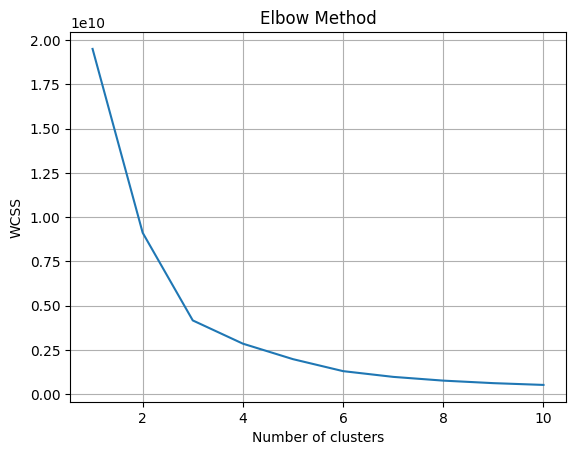

In [38]:
plt.plot(range(1, 11), wcss)
plt.title('WCSS vs Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
# Let's go with 7

In [41]:
def calc_homophily_ratio(nodes:pd.DataFrame, group_column:str) -> float:
    # create edges 
    edges = pd.merge(node, nodes, on=group_column)

    # calculate homophily 
    total_edges = len(edges)
    same_group_edges = len(edges[edges['group_x'] == edges['group_y']])
    homophily_ratio = same_group_edges / total_edges

    return homophily_ratio

In [ ]:
def process_file(file):
    df = pd.read_parquet(f"{dest}{file}")
    features = df[['x', 'y', 'z', 'time']]
    
    kmeans = KMeans(n_clusters=7)
    df['group'] = kmeans.fit_predict(features)
    
    ratio = calc_homophily_ratio(df, 'group')
    return file, ratio

global_stats = {}
for file in os.listdir(dest):
    file, ratio = process_file(file)
    global_stats[file] = ratio